# Exponential experiment using KS statistic:

In [53]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore
from scipy import stats

from clover import Scores
from clover import LocartSplit

from copy import deepcopy

from tqdm import tqdm
import itertools

In [54]:
quantile = stats.kstwobign.ppf(0.95)
print(quantile)

1.3580986393225505


## Functions to simulate from the exponential and compute KS statistic:

In [55]:
def sim_gamma(gamma_shape, gamma_scale, n, rng):

    X = rng.gamma(gamma_shape, gamma_scale, n)

    theoretical = np.sort(stats.gamma.cdf(X, a=gamma_shape, scale=gamma_scale))
    empirical = stats.ecdf(X)

    lambda_stat =  np.sqrt(n) * np.max(np.abs(theoretical - empirical.cdf.probabilities))

    return lambda_stat


# randomly sampling from gamma
def sample_gamma(n, N, rng):
    thetas = np.c_[rng.uniform(2, 8, n), rng.uniform(4, 10, n)]
    lambdas = np.zeros(n)
    i = 0
    for shape, scale in thetas:
        lambdas[i] = sim_gamma(
            gamma_shape=shape,
            gamma_scale=scale,
            n=N,
            rng=rng,
        )
        i += 1
    return thetas, lambdas

def naive(alpha, rng, B=1000, N=100, seed=250, naive_n=100):
    np.random.seed(seed)
    n_grid = round(np.sqrt(B / naive_n))
    a_s = np.linspace(4.0001, 9.9999, n_grid)
    b_s = np.linspace(2.0001, 7.9999, n_grid)

    quantiles = {}
    for shape, scale in itertools.product(b_s, a_s):
        lambda_stat = np.zeros(naive_n)
        for i in range(naive_n):  
            lambda_stat[i] = sim_gamma(
                gamma_shape=shape,
                gamma_scale=scale,
                n=N,
                rng=rng,
            )

        quantiles[(shape, scale)] = np.quantile(lambda_stat, q=1 - alpha)
    return quantiles

# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(thetas_values - x, axis=1)
        idx = thetas_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list


def sim_lambda(gamma_shape, gamma_scale, rng, B=1000, N=100):
    lambdas = np.zeros(B)
    for k in range(0, B):
        lambdas[k] = sim_gamma(gamma_shape = gamma_shape, gamma_scale = gamma_scale, rng = rng, n = N)

    return lambdas

In [56]:
def sim_lognormal(mu, sigma, n, rng):

    X = rng.lognormal(mean = mu, sigma = sigma, size = n)

    theoretical = np.sort(stats.lognorm.cdf(X, loc = mu, s = sigma))
    empirical = stats.ecdf(X)

    lambda_stat =  np.sqrt(n) * np.max(np.abs(theoretical - empirical.cdf.probabilities))

    return lambda_stat


# randomly sampling from gamma
def sample_lognormal(n, N, rng):
    thetas = np.c_[rng.uniform(-2.5, 2.5, n), rng.uniform(0.25, 2.5, n)]
    lambdas = np.zeros(n)
    i = 0
    for mu, sigma in thetas:
        lambdas[i] = sim_lognormal(
            mu=mu,
            sigma=sigma,
            n=N,
            rng=rng,
        )
        i += 1
    return thetas, lambdas

def naive(alpha, rng, B=1000, N=100, seed=250, naive_n=100):
    np.random.seed(seed)
    n_grid = round(np.sqrt(B / naive_n))
    a_s = np.linspace(-2.4999, 2.4999, n_grid)
    b_s = np.linspace(0.25001, 2.4999, n_grid)

    quantiles = {}
    for mu, sigma in itertools.product(a_s, b_s):
        lambda_stat = np.zeros(naive_n)
        for i in range(naive_n):  
            lambda_stat[i] = sim_lognormal(
            mu=mu,
            sigma=sigma,
            n=N,
            rng=rng,
        )

        quantiles[(mu, sigma)] = np.quantile(lambda_stat, q=1 - alpha)
    return quantiles

# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(thetas_values - x, axis=1)
        idx = thetas_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list


def sim_lambda(mu, sigma, rng, B=1000, N=100):
    lambdas = np.zeros(B)
    for k in range(0, B):
        lambdas[k] = sim_lognormal(mu, sigma, rng = rng, n = N)
    return lambdas

## Testing statistic invariance for small samples:

checking invariance by histograms:

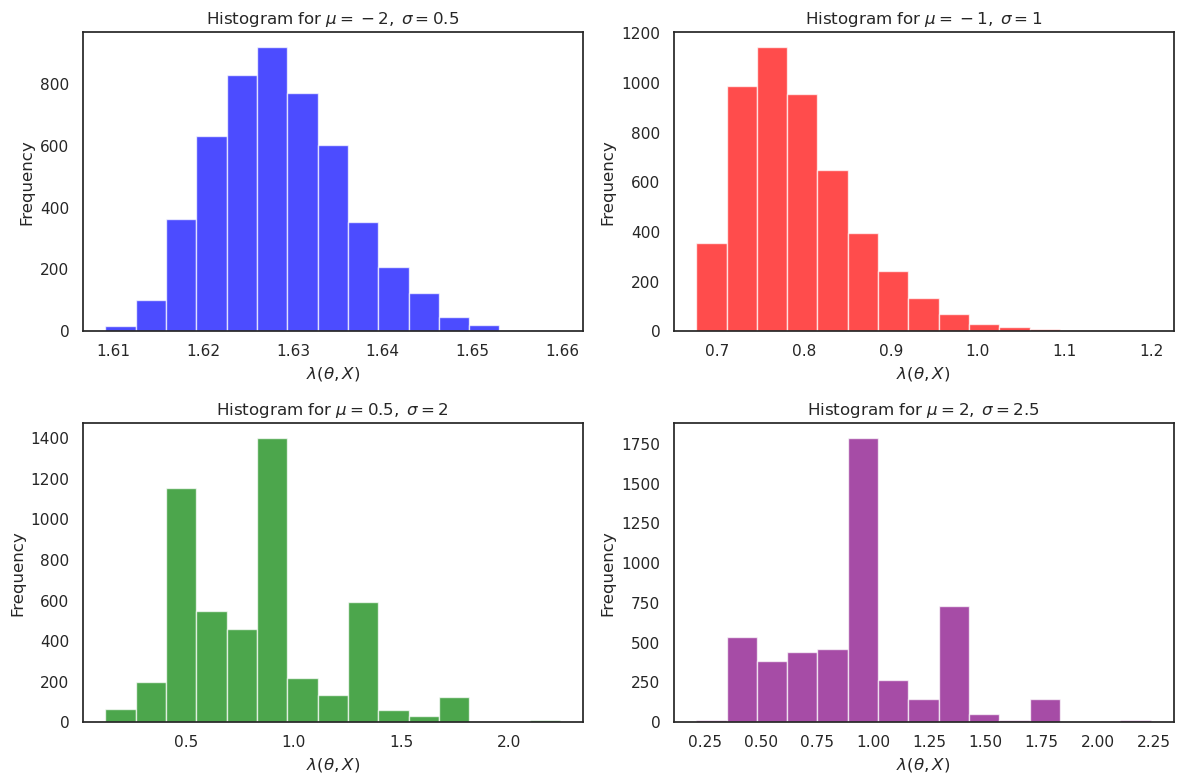

In [57]:
rng = np.random.default_rng(145)

sns.set(style="white", font_scale=1)
# plotting histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

lambdas_1 = sim_lambda(mu = -2, sigma = 0.5, rng = rng, N = 5, B = 5000)
axs[0, 0].hist(lambdas_1, bins=15, color="blue", alpha=0.7)
axs[0, 0].set_title(r"Histogram for $\mu = -2, \; \sigma = 0.5$")
axs[0, 0].set_xlabel(r"$\lambda(\theta, X)$")
axs[0, 0].set_ylabel("Frequency")

lambdas_2 = sim_lambda(mu = -1, sigma = 1, rng = rng, N = 5, B = 5000)
axs[0, 1].hist(lambdas_2, bins=15, color="red", alpha=0.7)
axs[0, 1].set_title(r"Histogram for $\mu = -1, \; \sigma = 1$")
axs[0, 1].set_xlabel(r"$\lambda(\theta, X)$")
axs[0, 1].set_ylabel("Frequency")

lambdas_3 = sim_lambda(mu = 0.5, sigma = 2, rng = rng, N = 5, B = 5000)
axs[1, 0].hist(lambdas_3, bins=15, color="green", alpha=0.7)
axs[1, 0].set_title(r"Histogram for $\mu = 0.5, \; \sigma = 2$")
axs[1, 0].set_xlabel(r"$\lambda(\theta, X)$")
axs[1, 0].set_ylabel("Frequency")

lambdas_4 = sim_lambda(mu = 2, sigma = 2.5, rng = rng, N = 5, B = 5000)
axs[1, 1].hist(lambdas_4, bins=15, color="purple", alpha=0.7)
axs[1, 1].set_title(r"Histogram for $\mu = 2, \; \sigma = 2.5$")
axs[1, 1].set_xlabel(r"$\lambda(\theta, X)$")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Testing for several N and B:

In [58]:
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 50,
    naive_n=500
):
    # fitting and predicting naive
    naive_quantiles = naive(alpha, rng = rng, B=B, N=N, naive_n= naive_n)
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    thetas_sim, model_lambdas = sample_lognormal(n=B, N=N, rng = rng)

    model_thetas = thetas_sim.reshape(-1, 2)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators= n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 2))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 2))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 2))

    # ks quantile
    ks_quantiles = np.tile(stats.kstwobign.ppf(1 - alpha), thetas.shape[0])

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
        "ks": ks_quantiles,
    }

    return quantile_dict

def compute_MAE_N(
    thetas,
    N=np.array([1, 10, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000, 20000]),
    alpha=0.05,
    n=1000,
    seed=45,
    n_estimators = 100,
    K = 40,
    min_samples_leaf=100,
    naive_n=100,
): 
    N_list = []
    methods_list = []
    mae_list = []
    se_list = []
    B_list = []

    rng = np.random.default_rng(seed)
    for N_fixed in N:
        for B_fixed in B:
            print(f'Computing for B = {B_fixed} and N = {N_fixed}')
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                n_estimators=n_estimators,
                K = K,
                naive_n=naive_n,
                rng = rng
            )
            err_data = np.zeros((thetas.shape[0], 5))
            l = 0
            for theta in thetas:
                # generating several lambdas
                stat = np.zeros(n)
                for i in range(0, n):
                    stat[i] = sim_lognormal(
                        mu=theta[0], 
                        sigma=theta[1], 
                        n=N_fixed, 
                        rng = rng,
                        )
                        
                # comparing coverage of methods
                locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(stat <= quantiles_dict["loforest"][l])
                boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(stat <= quantiles_dict["naive"][l])
                ks_cover = np.mean(stat <= quantiles_dict["ks"][l])
        
                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))
                err_ks = np.abs(ks_cover - (1 - alpha))
        
                # saving in numpy array
                err_data[l, :] = np.array([err_locart, err_loforest, err_boosting, err_naive, err_ks])
                l += 1
            
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive", "KS"])
            N_list.extend([N_fixed] * 5)
            B_list.extend([B_fixed] * 5)


    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

Testing:

In [59]:
n_out = 50
a_s = np.linspace(-2.4999, 2.4999, n_out)
b_s = np.linspace(0.25001, 2.4999, n_out)
thetas_grid = np.c_[list(itertools.product(a_s, b_s))]

In [65]:
mae_stats = compute_MAE_N(
    thetas_grid,
    N=np.array([5, 10, 50, 100]),
    B=np.array([1000, 5000, 10000, 15000]),
    naive_n=500,
    min_samples_leaf=300,
    n_estimators=200,
    seed = 1250,
    K = 40,
)

Computing for B = 1000 and N = 5
Computing for B = 5000 and N = 5
Computing for B = 10000 and N = 5
Computing for B = 15000 and N = 5
Computing for B = 1000 and N = 10
Computing for B = 5000 and N = 10
Computing for B = 10000 and N = 10
Computing for B = 15000 and N = 10
Computing for B = 1000 and N = 50


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

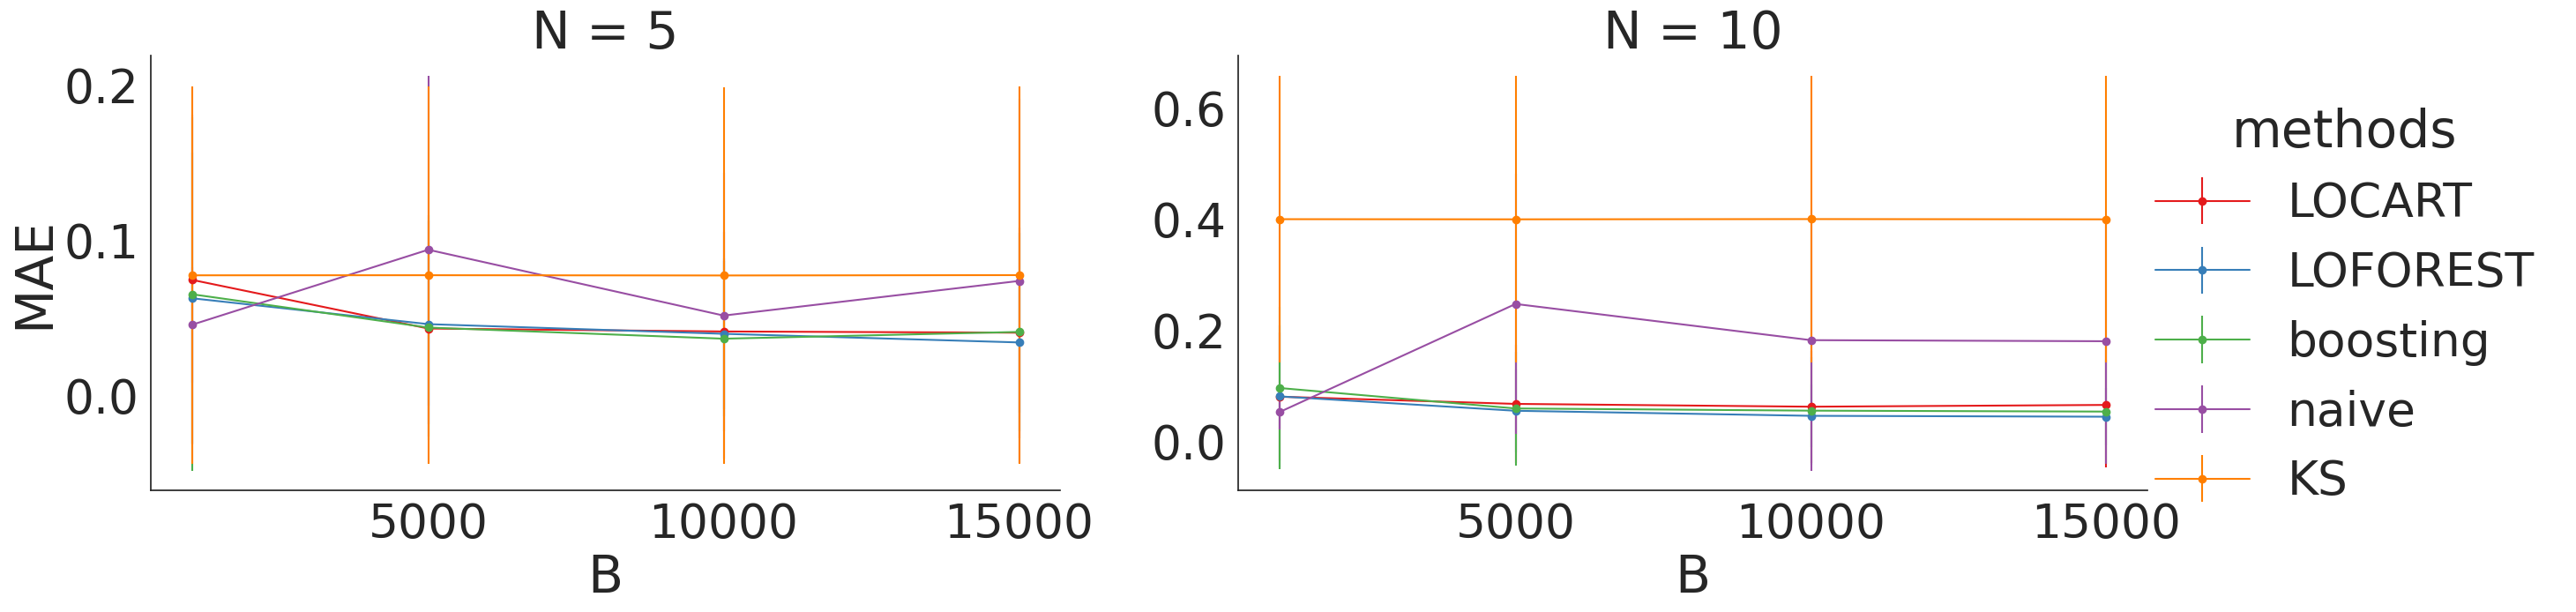

In [ ]:
# Create a line plot with error bars
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()